Данильченко Вадим

Классификация категорий обращений граждан в органы власти

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from google.colab import drive
from tqdm import trange

from keras.preprocessing.text import Tokenizer
from keras import utils

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls drive/'My Drive'/data/

 appeal_to_authorities.csv   Аппендицит.txt  'Тексты писателей.zip'
 digits.zip		     Гастрит.txt      Холицестит.txt
 geo_comment.xlsx	     Гепатит.txt      Эзофагит.txt
 geo.xlsx		     Дуоденит.txt     Энтерит.txt
 Images.zip		     Колит.txt	      Язва.txt
 middle_fmr.zip		     Панкреатит.txt


In [4]:
data = pd.read_csv(r"drive/My Drive/data/appeal_to_authorities.csv")
print(data.shape)
data.head()

(10059, 3)


,text,category,theme
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт,Запрос на льготы / субсидии
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ,Запрос юридической консультации
2,""" Спасибо Вам огромное за возобновление строит...",Строительство,Запрос юридической консультации
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт,Недовольство общее
4,Некоторое время назад для школьников и студент...,Дороги и транспорт,Запрос на льготы / субсидии


In [5]:
# пронумеруем категории 
data['target'] = data['category'].astype('category').cat.codes
# удалим примеры, для которых отсутствует метка класса
data = data[data['target']!=-1]
# data.dropna(subset='category', axis=1, inplace=True)
print(data.shape)
data['target'].value_counts()

(8262, 4)


6     2063
1     1686
4     1411
15     370
7      368
17     349
10     290
16     246
11     244
5      208
0      187
20     180
12     172
18     151
9      100
8       80
2       59
14      50
3       20
19      15
13      13
Name: target, dtype: int64

In [6]:
%%time
# обучим токенизатор
MAX_WORD_COUNT = 20000

tokenizer = Tokenizer(num_words=MAX_WORD_COUNT, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='UNK', char_level=False)
tokenizer.fit_on_texts(data['text'].tolist())
items = list(tokenizer.word_index.items())
print(len(items))

72541
CPU times: user 1.37 s, sys: 17.1 ms, total: 1.39 s
Wall time: 1.39 s


In [7]:
# преобразуем тексты в id (все слова, индексы которых будут больше MAX_WORD_COUNT, будут иметь индекс слова UNK)
X = tokenizer.texts_to_sequences(data['text'].tolist())
X[:2]

[[51,
  1661,
  114,
  78,
  183,
  157,
  486,
  15,
  1722,
  7,
  7563,
  4887,
  15,
  165,
  4888,
  2,
  5953,
  278,
  6,
  264,
  4,
  486,
  2299,
  18307,
  301,
  309,
  4,
  839,
  1061],
 [1661, 114, 786, 183, 654, 5, 552, 1, 116]]

In [18]:
# запишем в y индексы классов и преобразуем в one_hot вектор нулей длиной по количеству классов, имеющий 1 на пересечении индекса с нужным классом
from collections import Counter
y = data['target'].tolist()
CLASSES = len(set(y))
print('количество классов:', CLASSES)
y_cat = utils.to_categorical(y)
print('после преобразования:\n', y_cat[:2])
y_cat.shape

количество классов: 21
после преобразования:
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(8262, 21)

In [9]:
# посмотрим на среднюю длину сообщений, чтобы выбрать размер среза
from keras.preprocessing.text import text_to_word_sequence
data['length'] = data['text'].apply(lambda x: len(text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')))
data.groupby(['category'])['length'].mean()#.agg('mean')
# data['length'].loc[:3]

category
Бизнес                        160.176471
Благо­­устрой­­ство           103.998814
Борьба с коррупцией           211.305085
Демография                    159.300000
Дороги и транспорт            106.430191
Другое                        144.610577
ЖКХ                           136.521571
Здравоохранение               149.608696
Земельные отношения           185.912500
Культура                      183.640000
Образование и наука           159.651724
Органы власти                 192.864754
Правопорядок                  177.901163
Промышленность                183.615385
Сельское хозяйство            189.020000
Социальная сфера              152.208108
Спорт                         149.703252
Строительство                 147.690544
Труд и занятость населения    176.324503
Туризм                        199.866667
Экология                      124.927778
Name: length, dtype: float64

In [0]:
# функция будет делать срезы некоторой длины slice_len с шагом step в последовательности sequence, которая будет ей подана на вход
def get_slices(sequence, slice_len, step):
  slices = []
  max_len = len(sequence)

  start = 0
  while (start+step<=max_len):
    slices.append(sequence[start:start+slice_len])
    start+=step
  
  return slices

In [0]:
# функция добавляет к входящей последовательности индексов текстов значения в целевую переменную
def create_dataset(sequences, target, slice_len, step):
  classes = target.shape[1]
  seq_slices = [] 
  target_to_slice = []#[[] for _ in range(target.shape[0])]
  # запишем срезы индексов длиной slice_len для каждого текста
  for i in trange(len(sequences)):
    seq_slices_tmp = get_slices(sequences[i], slice_len, step)
    seq_slices+=seq_slices_tmp
    for j in seq_slices_tmp:
      target_to_slice.append(target[i])

  seq_slices = np.asarray(seq_slices)
  target_to_slice = np.asarray(target_to_slice)

  return (seq_slices, target_to_slice)

In [12]:
slice_len = 100
step = 50

x_new, y_new = create_dataset(X, y_cat, slice_len, step)
print(x_new.shape, y_new.shape)
print(x_new[0])
print(y_new[0])

100%|██████████| 8262/8262 [00:00<00:00, 52792.46it/s]


(18065,) (18065, 21)
[92, 537, 3, 3445, 1094, 2, 170, 1178, 17, 29, 80, 1, 1968, 96, 11451, 100, 2, 15819, 212, 15820, 15821, 1, 2, 1, 6824, 15822, 14, 1, 1968, 1639, 11, 1744, 2224, 80, 18308, 15823, 1968, 121, 12520, 1, 11451, 4, 803, 12521, 997, 5, 2224, 2051, 96, 15821, 7, 1203, 1427, 88, 2, 1, 13984, 140, 13, 88, 75, 19, 5, 504, 1, 7565, 1443, 14, 12522, 3, 1, 1, 3, 2613, 2, 6220, 55, 9, 170, 11452, 21, 24, 1, 4889, 93, 9043, 3590, 736, 8489, 32, 74, 70, 5076, 2, 1, 3, 487, 49, 109, 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=777)

In [14]:
# приведем к формату bag of words по длине словаря MAX_WORD_COUNT
x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())
x_train_bow.shape

(14452, 20000)

**WITHOUT EMBEDDING**

In [49]:
# создадим граф вычислений нейросети 1
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l1

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=20,
          batch_size=256,
          verbose=1)

Train on 14452 samples, validate on 3613 samples
Epoch 1/20
14452/14452 [==============================] - 2s 119us/step - loss: 2.8316 - accuracy: 0.2743 - val_loss: 2.6018 - val_accuracy: 0.3496
Epoch 2/20
14452/14452 [==============================] - 2s 112us/step - loss: 2.3821 - accuracy: 0.3671 - val_loss: 2.2347 - val_accuracy: 0.3869
Epoch 3/20
14452/14452 [==============================] - 2s 112us/step - loss: 2.0333 - accuracy: 0.4417 - val_loss: 1.9680 - val_accuracy: 0.4661
Epoch 4/20
14452/14452 [==============================] - 2s 112us/step - loss: 1.7574 - accuracy: 0.5393 - val_loss: 1.7593 - val_accuracy: 0.5411
Epoch 5/20
14452/14452 [==============================] - 2s 111us/step - loss: 1.5332 - accuracy: 0.6262 - val_loss: 1.5967 - val_accuracy: 0.6014
Epoch 6/20
14452/14452 [==============================] - 2s 112us/step - loss: 1.3506 - accuracy: 0.6997 - val_loss: 1.4662 - val_accuracy: 0.6396
Epoch 7/20
14452/14452 [==============================] - 2s 11

In [0]:
def history_plot(r):
  fig, ax1 = plt.subplots()

  t = np.arange(0, len(r.history['accuracy']), 1)

  ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
  ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax2 = ax1.twinx()


  ln3 = ax2.plot(t, r.history['accuracy'], color='b', label='accuracy')
  ln4 = ax2.plot(t, r.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
  ax2.set_ylabel('accuracy')

  lns = ln1+ln2+ln3+ln4
  labs = [l.get_label() for l in lns]
  ax1.legend(lns, labs, loc=0)

  fig.tight_layout()
  plt.show()

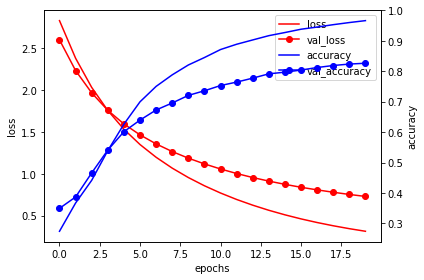

In [50]:
history_plot(model.history)

In [51]:
# создадим граф вычислений нейросети 2

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dense(100, activation='relu', name='dense_1'))
model.add(Dropout(0.2))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=20,
          batch_size=256,
          verbose=1)

Train on 14452 samples, validate on 3613 samples
Epoch 1/20
14452/14452 [==============================] - 2s 124us/step - loss: 2.9273 - accuracy: 0.2214 - val_loss: 2.7298 - val_accuracy: 0.2845
Epoch 2/20
14452/14452 [==============================] - 2s 116us/step - loss: 2.4916 - accuracy: 0.3205 - val_loss: 2.3001 - val_accuracy: 0.3476
Epoch 3/20
14452/14452 [==============================] - 2s 115us/step - loss: 2.1304 - accuracy: 0.4157 - val_loss: 1.9974 - val_accuracy: 0.4608
Epoch 4/20
14452/14452 [==============================] - 2s 114us/step - loss: 1.7966 - accuracy: 0.5212 - val_loss: 1.7274 - val_accuracy: 0.5408
Epoch 5/20
14452/14452 [==============================] - 2s 115us/step - loss: 1.5117 - accuracy: 0.6226 - val_loss: 1.5211 - val_accuracy: 0.6075
Epoch 6/20
14452/14452 [==============================] - 2s 115us/step - loss: 1.2854 - accuracy: 0.7007 - val_loss: 1.3604 - val_accuracy: 0.6618
Epoch 7/20
14452/14452 [==============================] - 2s 11

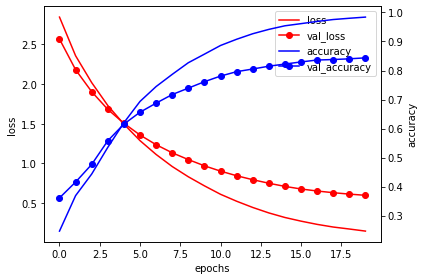

In [44]:
history_plot(model.history)

In [32]:
# создадим граф вычислений нейросети 3

model = Sequential()
model.add(Dense(100, activation='linear', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dropout(0.2, name='dropout_1'))
model.add(Dense(50, name='dense_2'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(name='batch_norm'))
model.add(Dropout(0.2, name='dropout_2'))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=20,
          batch_size=256,
          verbose=1)

Train on 14452 samples, validate on 3613 samples
Epoch 1/20
14452/14452 [==============================] - 2s 137us/step - loss: 2.9802 - accuracy: 0.1707 - val_loss: 2.8822 - val_accuracy: 0.4434
Epoch 2/20
14452/14452 [==============================] - 2s 118us/step - loss: 1.8793 - accuracy: 0.4918 - val_loss: 2.6652 - val_accuracy: 0.5954
Epoch 3/20
14452/14452 [==============================] - 2s 118us/step - loss: 1.3752 - accuracy: 0.6689 - val_loss: 2.4209 - val_accuracy: 0.6762
Epoch 4/20
14452/14452 [==============================] - 2s 119us/step - loss: 1.0436 - accuracy: 0.7792 - val_loss: 2.1515 - val_accuracy: 0.7274
Epoch 5/20
14452/14452 [==============================] - 2s 117us/step - loss: 0.8172 - accuracy: 0.8495 - val_loss: 1.8516 - val_accuracy: 0.7614
Epoch 6/20
14452/14452 [==============================] - 2s 116us/step - loss: 0.6411 - accuracy: 0.8968 - val_loss: 1.5513 - val_accuracy: 0.7894
Epoch 7/20
14452/14452 [==============================] - 2s 11

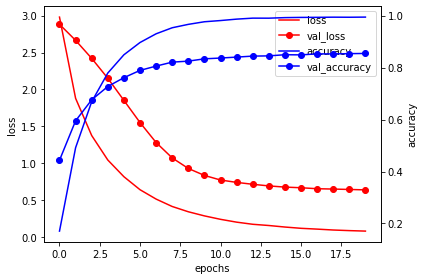

In [35]:
history_plot(model.history)

In [53]:
# создадим граф вычислений нейросети 4

model = Sequential()
model.add(Dense(200, activation='relu', input_dim=MAX_WORD_COUNT, name='input'))
model.add(Dropout(0.2, name='dropout_1'))
model.add(Dense(150, activation='relu',  name='dense_2'))
model.add(BatchNormalization(name='batch_norm'))
model.add(Dropout(0.2, name='dropout_2'))
model.add(Dense(150, activation='relu', name='dense_3'))
model.add(Dropout(0.2, name='dropout_3'))
model.add(Dense(100, activation='relu', name='dense_4'))
model.add(Dropout(0.1, name='dropout_4'))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_bow,
          y_train,
          validation_data=(x_test_bow, y_test),
          epochs=20,
          batch_size=256,
          verbose=1)

Train on 14452 samples, validate on 3613 samples
Epoch 1/20
14452/14452 [==============================] - 2s 145us/step - loss: 2.9966 - accuracy: 0.1098 - val_loss: 2.9950 - val_accuracy: 0.3523
Epoch 2/20
14452/14452 [==============================] - 2s 123us/step - loss: 2.3383 - accuracy: 0.3551 - val_loss: 2.8610 - val_accuracy: 0.4130
Epoch 3/20
14452/14452 [==============================] - 2s 124us/step - loss: 1.8904 - accuracy: 0.4532 - val_loss: 2.6898 - val_accuracy: 0.4498
Epoch 4/20
14452/14452 [==============================] - 2s 121us/step - loss: 1.6075 - accuracy: 0.5311 - val_loss: 2.4858 - val_accuracy: 0.5162
Epoch 5/20
14452/14452 [==============================] - 2s 122us/step - loss: 1.3464 - accuracy: 0.6135 - val_loss: 2.2255 - val_accuracy: 0.5945
Epoch 6/20
14452/14452 [==============================] - 2s 124us/step - loss: 1.0970 - accuracy: 0.6915 - val_loss: 1.8931 - val_accuracy: 0.6438
Epoch 7/20
14452/14452 [==============================] - 2s 12

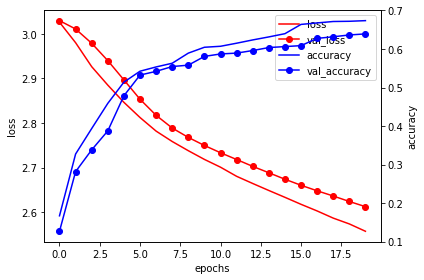

In [40]:
history_plot(model.history)

In [73]:
from keras.preprocessing.sequence import pad_sequences
x_train_pad = pad_sequences(x_train, maxlen=slice_len)
x_test_pad = pad_sequences(x_test, maxlen=slice_len)
x_train_pad.shape

(14452, 100)

**EMBEDDING**

In [89]:
# создадим граф вычислений нейросети 5 - с эмбеддингом
from keras.layers import Embedding, Flatten, SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_WORD_COUNT, 300, input_length=slice_len, name='embedding'))
model.add(SpatialDropout1D(0.4))
model.add(Dense(300, activation='linear', name='dense_0'))
model.add(Dropout(0.4))
model.add(Dense(200, name='dense_1'))# , activation='relu'
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(150, activation='relu', name='dense_2'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu', name='dense_3'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_pad,
          y_train,
          validation_data=(x_test_pad, y_test),
          epochs=100,
          batch_size=256,
          verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14452 samples, validate on 3613 samples
Epoch 1/100
14452/14452 [==============================] - 2s 119us/step - loss: 4.1855 - accuracy: 0.0517 - val_loss: 3.0816 - val_accuracy: 0.0166
Epoch 2/100
14452/14452 [==============================] - 1s 75us/step - loss: 3.9971 - accuracy: 0.0583 - val_loss: 3.1268 - val_accuracy: 0.0271
Epoch 3/100
14452/14452 [==============================] - 1s 75us/step - loss: 3.8469 - accuracy: 0.0698 - val_loss: 3.1403 - val_accuracy: 0.0296
Epoch 4/100
14452/14452 [==============================] - 1s 75us/step - loss: 3.6606 - accuracy: 0.0795 - val_loss: 3.1168 - val_accuracy: 0.0329
Epoch 5/100
14452/14452 [==============================] - 1s 74us/step - loss: 3.5266 - accuracy: 0.0991 - val_loss: 3.0809 - val_accuracy: 0.0324
Epoch 6/100
14452/14452 [==============================] - 1s 74us/step - loss: 3.3726 - accuracy: 0.1254 - val_loss: 3.0179 - val_accuracy: 0.0501
Epoch 7/100
14452/14452 [==============================] - 1s 

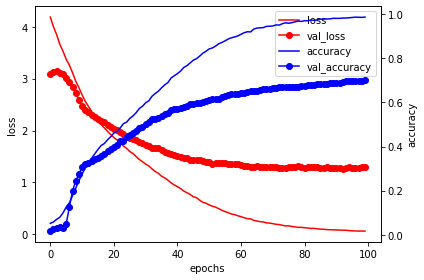

In [90]:
history_plot(model.history)

**EMBEDDING + WORD2VEC**

In [143]:
!pip install pymorphy2

In [154]:
%%time
from keras.preprocessing.text import text_to_word_sequence
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
morph = MorphAnalyzer()
messages = data['text'].tolist()
data_normalized = [[] for _ in range(len(messages))]

for i in range(len(messages)):
  tmp_seq = text_to_word_sequence(messages[i], filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
  for word in tmp_seq:
    data_normalized[i].append(morph.parse(str(word))[0].normal_form)

print(len(data_normalized))
print(data_normalized[:2])

8262
[['здравствовать', 'подсказать', 'пожалуйста', 'можно', 'ли', 'сделать', 'проезд', 'для', 'школьник', 'по', 'льготный', 'цена', 'для', 'человек', 'работать', 'в', 'бюджетный', 'организация', 'с', 'ребёнок', 'на', 'проезд', 'уходить', 'значительный', 'часть', 'деньга', 'на', 'оплата', 'проезд'], ['подсказать', 'пожалуйста', 'иметь', 'ли', 'право', 'не', 'платить', 'какп', 'ремонт']]
CPU times: user 3min 26s, sys: 149 ms, total: 3min 27s
Wall time: 3min 27s


In [181]:
# обучим модель word2vec
from gensim.models import Word2Vec
wvec = Word2Vec(data_normalized, size=300, window=5, min_count=3, workers=-1)
len(wvec.wv.vocab)

13128

In [0]:
# сделаем свой словарь id слов по словарю word2vec
id2word = {k+1:v for k,v in enumerate(wvec.wv.vocab)}
id2word[0] = 'UNK'
word2id = {v:k for k,v in id2word.items()}

In [231]:
# превратим текст в последовательность индексов слов по словарю word2vec, остальные слова упадут в UNK
data_train_seq = [[] for _ in range(len(data_normalized))]

for i in trange(len(data_normalized)):
  for word in data_normalized[i]:
    if word not in word2id:
      word = 'UNK'
    data_train_seq[i].append(word2id[word])        

print(data_train_seq[:2])





  0%|          | 0/8262 [00:00<?, ?it/s]



 26%|██▌       | 2132/8262 [00:00<00:00, 21315.65it/s]



 54%|█████▍    | 4470/8262 [00:00<00:00, 21892.96it/s]



100%|██████████| 8262/8262 [00:00<00:00, 24124.80it/s]

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 8, 13, 14, 15, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24, 20, 25, 7], [2, 3, 26, 5, 27, 28, 29, 0, 30]]


In [184]:
# преобразуем датасетв последовательность срезов длины slice_len и шагом step, каждому срезу сопоставим свой класс
slice_len = 30
step = 10
x_, y_ = create_dataset(data_train_seq, y_cat, slice_len, step)
print('train shapes:', x_.shape, y_.shape)
print('x:\n', x_[:2])
print('y:\n', y_[:2])





  0%|          | 0/8262 [00:00<?, ?it/s]



100%|██████████| 8262/8262 [00:00<00:00, 64090.72it/s]


train shapes: (106626,) (106626, 21)
x:
 [list([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 8, 13, 14, 15, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24, 20, 25, 7])
 list([11, 12, 8, 13, 14, 15, 16, 17, 18, 19, 20, 7, 21, 22, 23, 24, 20, 25, 7])]
y:
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [186]:
# сформируем эмбеддинг из вектора word2vec по словарю word2vec
embed_matrix = np.zeros((len(id2word), wvec.wv.vector_size))
for i in trange(embed_matrix.shape[0]):
  word = id2word[i]
  if word in wvec.wv:
    embed_matrix[i] = wvec.wv.__getitem__(word)





100%|██████████| 13129/13129 [00:00<00:00, 285753.66it/s]


In [187]:
# дополним последовательность до длины slice_len, заполнив остальные части нулями
from keras.preprocessing.sequence import pad_sequences
x_pad = pad_sequences(x_, slice_len)
print(x_pad.shape)
print('x_pad:\n', x_pad[:2])

(106626, 30)
x_pad:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12  8 13 14 15 16 17 18 19 20  7 21
  22 23 24 20 25  7]
 [ 0  0  0  0  0  0  0  0  0  0  0 11 12  8 13 14 15 16 17 18 19 20  7 21
  22 23 24 20 25  7]]


In [188]:
# разобьем на тренировочную и тестовую выборки
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_pad, y_, test_size=0.2, random_state=777)
print('x_test:\n', x_test_[:2])
print('y_test:\n', y_test_[:2])

x_test:
 [[   23   382   137   464    59  7289  1435  1908     8 10972   402    51
   2279     0   708    10  1372  4128  2446  1249  3181  3773  3724   107
    399  1916  1811   109  1833   399]
 [    0     0     0     0     0     0   200  4273     0    15   892   106
    311   424   134   154   316  1161  5711   382    18  3727    15  1784
   2723   305   184    20  1054   366]]
y_test:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [201]:
# создадим граф вычислений нейросети 6 - с эмбеддингом на word2vec
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, InputLayer, Flatten, LeakyReLU, PReLU, SpatialDropout1D
from keras.optimizers import Adam
from keras.regularizers import l1

model = Sequential()
model.add(Embedding(embed_matrix.shape[0], wvec.wv.vector_size, input_length=slice_len, trainable=True, name='embedding', weights=[embed_matrix]))#
model.add(SpatialDropout1D(0.1))
model.add(Dense(300, activation='linear', name='input_dense'))
model.add(Dropout(0.4, name='dropout_1'))
model.add(Dense(200, name='dense_2'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(name='batch_norm'))
model.add(Dense(100, name='dense_3'))
model.add(PReLU())
model.add(Dropout(0.3, name='dropout_2'))
model.add(Flatten())
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_,
          y_train_,
          validation_data=(x_test_, y_test_),
          epochs=30,
          batch_size=128,
          verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 85300 samples, validate on 21326 samples
Epoch 1/30
85300/85300 [==============================] - 5s 59us/step - loss: 2.0190 - accuracy: 0.4092 - val_loss: 1.6816 - val_accuracy: 0.5548
Epoch 2/30
85300/85300 [==============================] - 5s 56us/step - loss: 1.3662 - accuracy: 0.6040 - val_loss: 1.2647 - val_accuracy: 0.6349
Epoch 3/30
85300/85300 [==============================] - 5s 55us/step - loss: 1.0199 - accuracy: 0.7004 - val_loss: 1.0519 - val_accuracy: 0.6887
Epoch 4/30
85300/85300 [==============================] - 5s 55us/step - loss: 0.7689 - accuracy: 0.7689 - val_loss: 0.9110 - val_accuracy: 0.7267
Epoch 5/30
85300/85300 [==============================] - 5s 55us/step - loss: 0.5904 - accuracy: 0.8216 - val_loss: 0.8127 - val_accuracy: 0.7585
Epoch 6/30
85300/85300 [==============================] - 5s 55us/step - loss: 0.4713 - accuracy: 0.8540 - val_loss: 0.7387 - val_accuracy: 0.7772
Epoch 7/30
85300/85300 [==============================] - 5s 54us/st

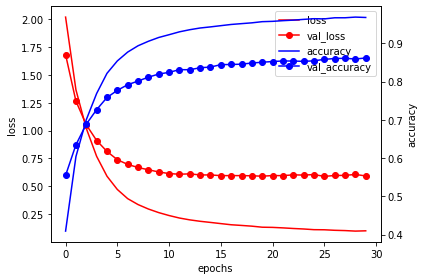

In [202]:
history_plot(model.history)

In [198]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           3938700   
_________________________________________________________________
spatial_dropout1d_32 (Spatia (None, 30, 300)           0         
_________________________________________________________________
input_dense (Dense)          (None, 30, 400)           120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 300)           120300    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 30, 300)           0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 30, 300)         

#### лучший результат классификации обращений с помощью эмбеддинга на word2vec. Модель с эмбеддингом без заранее подготовленных векторов не показала хорошего качества и очень быстро переобучалась, а остальные модели, где был применен BOW, показали схожее качество c 6й моделью (accuracy у всех около 0.83), также у 2й и 4й заметно, что есть еще потенциал для роста.

In [204]:
# посмотрим на количество примеров по классам в валидационной выборке
print('количество элементов по классам в тестовой выборке')
Counter([np.argmax(i) for i in y_test_])

количество элементов по классам в тестовой выборке


Counter({0: 537,
         1: 3296,
         2: 234,
         3: 65,
         4: 2931,
         5: 554,
         6: 5507,
         7: 1077,
         8: 307,
         9: 380,
         10: 879,
         11: 963,
         12: 581,
         13: 47,
         14: 205,
         15: 1089,
         16: 706,
         17: 955,
         18: 531,
         19: 55,
         20: 427})

в исходных данных есть классы с малым количеством примеров и раньше был шанс, что какого-то из этих классов не окажется в валиационной выборке и был вариант их исключить, но количество примеров получилось нарастить с помощью нарезки на элементы меньшего размера (длины slice_len) с некоторым шагом step. Есть вариант на основе этих примеров еще больше нарастить классы, принудительно добавив в выборку сгенерированных соседей и окрестности элементов класса. Попробуем на них обучить модель и посмотрим каой будет перфоманс

### борьба с несбалансированной выборкой наращением количества примеров миноритарных классов

In [205]:
!pip install imblearn

In [240]:
# библиотека сгенерирует примеры для миноритарных классов
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
x_pad_ros, y_ros = ros.fit_resample(x_pad, y_)

print(x_pad_ros.shape)
print('x_pad:\n', x_pad_ros[:2])

(571956, 30)
x_pad:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12  8 13 14 15 16 17 18 19 20  7 21
  22 23 24 20 25  7]
 [ 0  0  0  0  0  0  0  0  0  0  0 11 12  8 13 14 15 16 17 18 19 20  7 21
  22 23 24 20 25  7]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [243]:
# разобьем на тренировочную и тестовую выборки
x_train_ros, x_test_ros, y_train_ros, y_test_ros = train_test_split(np.asarray(x_pad_ros), y_ros, test_size=0.2, random_state=777)
print('x_test:\n', x_test_ros[:2])
print('y_test:\n', y_test_ros[:2])

x_test:
 [[   0 1439   28  151 1540 1540   15  459 3847 3389   20   71 2748   62
    19  558 2101  104   15  263 2748  106  204   77  171 6234 6530 6233
   459   19]
 [1640   50 9311  290 1598  378 3916  104  298  378   51  258  113  324
  5350  459 5349   62  258   51  185  486  194   28 3399   92   28  159
    20    0]]
y_test:
 [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


In [245]:
# создадим граф вычислений нейросети 7 - с эмбеддингом на word2vec + наращенным количеством примеров до размеров максимального класса
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, InputLayer, Flatten, LeakyReLU, PReLU, SpatialDropout1D
from keras.optimizers import Adam
from keras.regularizers import l1

model = Sequential()
model.add(Embedding(embed_matrix.shape[0], wvec.wv.vector_size, input_length=slice_len, trainable=True, name='embedding', weights=[embed_matrix]))#
model.add(SpatialDropout1D(0.1))
model.add(Dense(300, activation='linear', name='input_dense'))
model.add(Dropout(0.4, name='dropout_1'))
model.add(Dense(200, name='dense_2'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(name='batch_norm'))
model.add(Dense(100, name='dense_3'))
model.add(PReLU())
model.add(Dropout(0.3, name='dropout_2'))
model.add(Flatten())
model.add(Dense(CLASSES, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=1e-4))

model.fit(x_train_ros,
          y_train_ros,
          validation_data=(x_test_ros, y_test_ros),
          epochs=10,
          batch_size=128,
          verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 457564 samples, validate on 114392 samples
Epoch 1/10
457564/457564 [==============================] - 26s 56us/step - loss: 0.8851 - accuracy: 0.7463 - val_loss: 0.2266 - val_accuracy: 0.9361
Epoch 2/10
457564/457564 [==============================] - 25s 56us/step - loss: 0.2453 - accuracy: 0.9254 - val_loss: 0.1298 - val_accuracy: 0.9630
Epoch 3/10
457564/457564 [==============================] - 26s 56us/step - loss: 0.1667 - accuracy: 0.9479 - val_loss: 0.0979 - val_accuracy: 0.9719
Epoch 4/10
457564/457564 [==============================] - 25s 55us/step - loss: 0.1294 - accuracy: 0.9595 - val_loss: 0.0818 - val_accuracy: 0.9765
Epoch 5/10
457564/457564 [==============================] - 25s 55us/step - loss: 0.1077 - accuracy: 0.9662 - val_loss: 0.0708 - val_accuracy: 0.9794
Epoch 6/10
457564/457564 [==============================] - 25s 55us/step - loss: 0.0938 - accuracy: 0.9706 - val_loss: 0.0639 - val_accuracy: 0.9812
Epoch 7/10
457564/457564 [======================

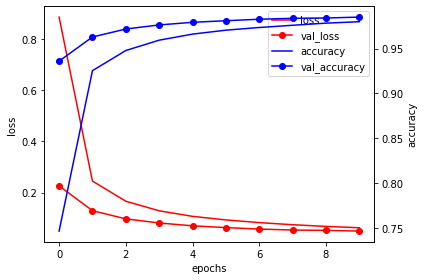

In [246]:
history_plot(model.history)

In [247]:
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           3938700   
_________________________________________________________________
spatial_dropout1d_38 (Spatia (None, 30, 300)           0         
_________________________________________________________________
input_dense (Dense)          (None, 30, 300)           90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 200)           60200     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 30, 200)           0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 30, 200)         

### в результате модель отлично обучилась, точность близка к единице